In [1]:
import numpy as np
from scipy.stats import ks_2samp, ks_1samp, kstest
import json
import pandas as pd
import matplotlib.pyplot as plt
from random import choices
import os
from scipy.stats import bernoulli
from scipy.stats import zipf

In [2]:
import re
def match_regex_array(files, regex):
    matches = [re.findall(regex, f) for f in files]
    matches = ["./sim_results/" + m[0] for m in matches if len(m) > 0 ]
    return matches

In [3]:
def get_selected_scenarios(simulator_path):    
    U_MATRIX        = ['lastfm_U_matrix.mat', 'movielens1k_U_matrix.mat']
    POPULARITY      = [0, 1]
    ALPHA           = [0.99, 0.8, 0.5]
    NN              = [2, 5, 10]
    CACHE           = [10]#[5, 10, 20]
    POLICY          = ['top']
    QQ              = [0.5, 0.8, 0.9, 1.0]
    LL              = [-1, 1, 40]   # L=1 corresponds to single-step (or, myopic) NA optim algorithm, and L=40 to sequential NA optim algorithm
    W_bfs           = [1, 2] # this is times the N, i.e., 1*N, 2*N
    D_bfs           = [2]
    files = []
    i=1
    for U in U_MATRIX:
        if U == 'lastfm_U_matrix.mat':
            K = 757
        else:
            K = 1060
        for pop in POPULARITY:
            for a in ALPHA:
                for N in NN:
                    for C in CACHE:
                        for cp in POLICY:
                            for q in QQ:
                                for L in LL:
                                    for W in W_bfs:
                                        for D in D_bfs:
                                            if L>0:
                                                out_file = simulator_path + 'sim_results/sim_results_U{}_pop{}_a{}_N{}_C{}_CP{}_Q{}_L{}.json'.format(U.split('_')[0], pop, a, N, C, cp, q, L)
                                            else: 
                                                out_file = simulator_path + 'sim_results/sim_results_U{}_pop{}_a{}_N{}_C{}_CP{}_Q{}_cabaret_W{}_D{}.json'.format(U.split('_')[0], pop, a, N, C, cp, q, W, D)
                                            if not os.path.exists(out_file):
                                                continue
                                            if L==1:
                                                plot_format = 'ok'
                                            elif L==40:
                                                plot_format = 'xr'
                                            elif L==-1:
                                                plot_format = '^b'
                                            else:
                                                error('Not correct parameter L')
                                            try:
                                                files.append(out_file.split("/")[-1])
                                            except Exception as e:
                                                print(e)
                                                continue
    return files

In [4]:
# Apply KS-test using a large number of samples from the reference distribution 
# and a small sample from a "test" (in this case, the Network-Aware) distribution multiple times
# Each test sample represents a bot consuming contents from NA-distribution
# Function returns the mean of the p_values for all KS-tests performed for each bot
# and the proportion of null hypothesis rejection, i.e., samples were not generated from the same distribution
def covertness_kstest(ref_dist, test_dist, population, ref_dist_size=10**6, test_dist_size=10**3, N_bots = 100, rounds=30):
    p_values_mean_rounds = []
    rejection_proportions_rounds = []
    ref_dist_large_samples = choices(population, ref_dist, k=ref_dist_size)
    for i in range(rounds):
        p_values = []        
        null_hypothesis_rejections = 0
        for j in range(N_bots):
            test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
            ks = ks_2samp(ref_dist_large_samples, test_dist_samples)
            p_values.append(ks.pvalue)
            if (ks.pvalue < 0.05):
                null_hypothesis_rejections += 1
        p_values_mean = np.mean(p_values)
        null_hypothesis_rejections /= N_bots

        p_values_mean_rounds.append(p_values_mean)
        rejection_proportions_rounds.append(np.mean(null_hypothesis_rejections))
    return p_values_mean_rounds, rejection_proportions_rounds

In [5]:
# aggregated mode
def covertness_kstest_aggregate(baseline_samples, test_dist, population, test_dist_size=10**3, N_bots = 100, rounds=30):
    p_values_rounds = []
    null_hypothesis_rejections = 0
    for i in range(rounds):
        # print("round ", i, end=' ')
        test_agg_samples = []
        for j in range(N_bots):
            test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
            test_agg_samples += test_dist_samples
        ks = ks_2samp(baseline_samples, test_agg_samples)
        if (ks.pvalue < 0.05):
            null_hypothesis_rejections += 1
        p_values_rounds.append(ks.pvalue)        
    return p_values_rounds, null_hypothesis_rejections/rounds

In [6]:
# aggregated mode simplified because samples per bot it's i.i.d and doesn't need bots
def covertness_kstest_aggregate(baseline_samples, test_dist, population, test_dist_size=10**3, rounds=30):
    p_values_rounds = []
    null_hypothesis_rejections = 0
    for i in range(rounds):
        # print("round ", i, end=' ')
        test_agg_samples = choices(population, test_dist, k=test_dist_size)
        ks = ks_2samp(baseline_samples, test_agg_samples)
        if (ks.pvalue < 0.05):
            null_hypothesis_rejections += 1
        p_values_rounds.append(ks.pvalue)        
    return null_hypothesis_rejections/rounds


In [7]:
# aggregated mode RANDOM CONTENTS PER BOT
# def covertness_kstest_aggregate_random_contents_per_bot(baseline_samples, test_dist, population, contents_per_user_population, contents_per_user_dist, N_bots = 100, rounds=30):
#     p_values_rounds = []
#     null_hypothesis_rejections = 0
#     for i in range(rounds):
#         # print("round ", i, end=' ')
#         test_agg_samples = []
#         for j in range(N_bots):
#             test_dist_size = choices(contents_per_user_population, contents_per_user_dist, k=1)[0]
#             test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
#             test_agg_samples += test_dist_samples
#         # print(len(test_agg_samples), end=",")
#         ks = ks_2samp(baseline_samples, test_agg_samples)
#         if (ks.pvalue < 0.05):
#             null_hypothesis_rejections += 1
#         p_values_rounds.append(ks.pvalue)        
#     return p_values_rounds, null_hypothesis_rejections/rounds

In [8]:
# random walker baseline sample generated with random walkers too!

# ORIGINAL

# def generate_samples_with_rw(p0, R, N, alpha, N_bots, contents_per_bot, rounds):       
#     consumed = []
#     for i in range(N_bots):            
#         first_content = choices(population, p0, k=1)[0]            
#         consumed.append(first_content)
#         current_content = first_content
#         for k in range(contents_per_bot):
#             follow_recommendation = bernoulli.rvs(p=alpha, size=1)[0]
#             if follow_recommendation:
#                 ri = R[current_content, :]
#                 ri_idx = np.where(ri > 0)[0] # index of > 0 elements
#                 content = choices(population=ri_idx, weights=ri[ri_idx]/ri[ri_idx].sum(), k=1)[0]
#             else:
#                 content = choices(population, p0, k=1)[0]
#             current_content = content
#             consumed.append(current_content)
#     return consumed

# def covertness_kstest_random_walker(baseline_samples, p0, R, N, alpha, N_bots, contents_per_bot, rounds, R_top=False):
#     R = np.array(R)
#     p0 = np.array(p0)
#     population = np.arange(len(p0))
#     null_hypothesis_rejections = 0
#     for i in range(rounds):        
#         consumed = []
#         for j in range(N_bots):            
#             first_content = choices(population, p0, k=1)[0]            
#             consumed.append(first_content)
#             current_content = first_content
#             for k in range(contents_per_bot):
#                 follow_recommendation = bernoulli.rvs(p=alpha, size=1)[0]
#                 if follow_recommendation:
#                     ri = R[current_content, :]
#                     ri_idx = np.where(ri > 0)[0] # index of > 0 elements
#                     content = choices(population=ri_idx, weights=ri[ri_idx]/ri[ri_idx].sum(), k=1)[0]
#                 else:
#                     content = choices(population, p0, k=1)[0]
#                 current_content = content
#                 consumed.append(current_content)
#         ks = ks_2samp(baseline_samples, consumed)
#         if (ks.pvalue < 0.05):
#             null_hypothesis_rejections += 1
#     return null_hypothesis_rejections/rounds

In [21]:
# random walker baseline sample generated with random walkers too!

def generate_first_contents_for_bots(population, p0, N_bots):
    first_contents = choices(population, p0, k=N_bots)
#     first_contents = []
#     for _ in range(N_bots):            
#         first_content = choices(population, p0, k=1)[0]
#         first_contents.append(first_content)
    return first_contents

def generate_samples_with_rw(population, p0, R, N, alpha, N_bots, contents_per_bot):       
    consumed = []
    for _ in range(N_bots):            
        first_content = choices(population, p0, k=1)[0]            
        consumed.append(first_content)
        current_content = first_content
        for _ in range(contents_per_bot):
            follow_recommendation = bernoulli.rvs(p=alpha, size=1)[0]
            if follow_recommendation:
                ri = R[current_content, :]
                ri_idx = np.where(ri > 0)[0] # index of > 0 elements
                content = choices(population=ri_idx, weights=ri[ri_idx]/ri[ri_idx].sum(), k=1)[0]
            else:                
                content = choices(population, p0, k=1)[0]
            current_content = content
            consumed.append(current_content)
    return consumed

def generate_samples_with_rw_first_contents(bots_first_contents, population, p0, R, N, alpha, N_bots, contents_per_bot):
    consumed = []
    for i in range(N_bots):            
        bot_first_content = bots_first_contents[i]    
#         first_content = choices(population, p0, k=1)[0]            
        consumed.append(bot_first_content)
        current_content = bot_first_content
        for _ in range(contents_per_bot-1):
            follow_recommendation = bernoulli.rvs(p=alpha, size=1)[0]
            if follow_recommendation:
                ri = R[current_content, :]
                ri_idx = np.where(ri > 0)[0] # index of > 0 elements
                content = choices(population=ri_idx, weights=ri[ri_idx]/ri[ri_idx].sum(), k=1)[0]
            else:                
                content = choices(population, p0, k=1)[0]
            current_content = content
            consumed.append(current_content)
    return consumed
def covertness_kstest_random_walker(p0, R_BS, R_NA, N, alpha, N_bots, contents_per_bot, rounds):
    p0 = np.array(p0)
    R_BS = np.array(R_BS)
    R_NA = np.array(R_NA)    
    population = np.arange(len(p0))
    null_hypothesis_rejections = 0
    first_contents = generate_first_contents_for_bots(population, p0, N_bots)
    baseline_sample = generate_samples_with_rw_first_contents(first_contents, population, p0, R_BS, N, alpha, N_bots, 1000)    
    for i in range(rounds):      
        consumed = generate_samples_with_rw_first_contents(first_contents, population, p0, R_NA, N, alpha, N_bots, contents_per_bot)
        ks = ks_2samp(baseline_sample, consumed)
        if (ks.pvalue < 0.05):
            null_hypothesis_rejections += 1
    return null_hypothesis_rejections/rounds
                

In [22]:
from os.path import exists

def ci_proportion(p_hat, n):
    std_hat = np.sqrt((p_hat*(1-p_hat))/n)
    lower = p_hat - 1.96*std_hat
    upper = p_hat + 1.96*std_hat
    return lower, p_hat, upper

def save_confidence_intervals(cis, test_dist_sizes, rounds, bots):
    filename = "confidence_interval_test_size" + "tds" + str(test_dist_sizes[0]) + \
        "-" + str(test_dist_sizes[-1]) + "_rounds_" + str(rounds) + \
        "_bots_" + str(bots) + ".txt"
    if (not exists(filename)):
        lowers = np.array([cis[i][0] for i in range(len(cis))])
        means = np.array([cis[i][1] for i in range(len(cis))])
        uppers = np.array([cis[i][2] for i in range(len(cis))])
        f = open(filename, "w")
        n_intervals = len(means)
        for i in range(n_intervals):            
            f.write(str(lowers[i]) + "," + str(means[i]) + "," + \
                    str(uppers[i]) + "\n")
        f.close()
    else:
        print("{} file already exists".format(filename))
    

In [23]:
def plot_confidence_intervals(x, filename, fig, ax, label, color):
    try:
        f = open(filename, "r")
        cis = np.array([np.array(line.rstrip().split(",")).astype(float) for line in f.readlines()])        
        lowers = np.around(cis[:, 0], decimals=2)
        means = np.around(cis[:, 1], decimals=2)
        uppers = np.around(cis[:, 2], decimals=2)
        print(uppers)
        if not fig or not ax:
            fig, ax = plt.subplots()
        ax.plot(x, means, label=label, color=color)
        ax.fill_between(x, lowers, uppers, color=color, alpha=.1)
#         plt.xlabel("Perturbed Distribution Sample")
        plt.xlabel("Contents per bot")
        plt.ylabel("Proportion of null hypothesis rejections")
        # plt.savefig("proportions_nbots30.png")
        # plt.show()
    except Exception as e:
        print(e)

In [24]:
def kl(p,q,alpha=0):
	'''
	Returns the KL distance between the two distributions p1 and p2. In case the parameter "alpha" is >0, it returns a smoothed version of the KL distance [Steck18].
	If the KL distance diverges (becomes inf) then the function returns the value np.nan

	[Steck18] Harald Steck. 2018. Calibrated recommendations. In ACM RecSys. ACM, 154–162
	'''
	d = [np.nan]*len(p) # initialize the list with the kl distance per item in the distribution
	q_smooth = [(1-alpha)*q[i]+ alpha*p[i]  for i in range(len(p))]
	for i in range(len(p)):
		if p[i]==0:
			d[i] = [0]
		else:
			if q_smooth[i]==0:
				d[i] = np.nan # the KL metrics diverges (becomes inf)
			else:
				d[i] = p[i]*np.log(p[i]/q_smooth[i])
	if alpha==0:
		return np.sum(d)
	else:
		return np.sum(d) / np.log(1/alpha)
    
def p_fairness(pNA,pBS,metric):
	'''
	This method receives two lists, representing content demand distributions (p[i] is the fraction of demand for the i^{th} content), 
	and a string that denotes which fairness measure will be used, 
	and returns a value for the fairness measure (or, "difference") of the given lists
	Input:
		pNA: a list of the first content demand distribution; this correspongs to the network-aware (NA) RS case
		pBS: a list of the second content demand distribution (should be of the same length with pNA); this correspongs to the baseline (BS) RS case
		metric: a string to denote which fairness measure to be used; it can take values {'avg', 'sum', 'max', 'kl', 'kl-smooth'}

	'''
	if metric=='avg':
		f = 0.5 * np.sum([np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))])
	elif metric=='sum':
		f = np.sum([np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))])
	elif metric=='max':
		r = [np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))]
		f = np.max([np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))])
	elif metric=='kl':
		f = kl(pNA,pBS)
	elif metric=='kl-inv':
		f = kl(pBS,pNA)
	elif metric=='kl-smooth':
		f = kl(pNA,pBS,alpha=0.01)
	elif metric=='kl-smooth-inv':
		f = kl(pBS,pNA,alpha=0.01)
	else:
		raise ValueError('The given metric "{}" is not within the available options'.format(metric))
	return f

In [25]:
def rejections_in_function_of_sample_size_and_fairness(file, n_bots = 10, n_rounds=30, f_metrics=['max', 'avg', 'kl-smooth-inv']):
    # x test sample sizes VARIES
    # y fairness CONSTANT
    # z rejections VARIES
    alpha = float(file.split('/sim_results_')[1].split('_')[2][1:])
    N = int(file.split('/sim_results_')[1].split('_')[3][1:])
    data = json.load(open(file))
    ref_dist_size=10**3
    ref_dist = data['pi_bs']
    catalog_size = len(data['p0'])
    population = np.arange(catalog_size)
    ref_dist_samples = choices(population, ref_dist, k=ref_dist_size)
    proportions = []
    test_sample_sizes = np.linspace(10, 100, 10).astype(int)
    for tds in test_sample_sizes:
#         print(tds, end=',')
        contents_per_bot = tds
        proportion = covertness_kstest_random_walker(ref_dist_samples, \
                                                      data['p0'], \
                                                   data['R_NA'], \
                                                   N, alpha, n_bots,\
                                                   contents_per_bot,\
                                                   n_rounds)
        proportions.append(proportion)
#     print(file, end=',')
    x = test_sample_sizes
    y = proportions
    z = {}
    for f_metric in f_metrics:
        fairness = p_fairness(data['pi_final_NA'], data['pi_bs'], f_metric)
        z[f_metric] = np.repeat(fairness, len(x))    
    return x, y, z

    

In [26]:
# Confidence Interval for i.i.d
def get_rejections_cis_filename_iid(simulator_results_path, file, n_rounds):
    alpha = float(file.split('sim_results_')[1].split('_')[2][1:])
    N = int(file.split('sim_results_')[1].split('_')[3][1:])
    data = json.load(open(simulator_results_path + file))
    test_sample_sizes = np.linspace(10, 100, 10).astype(int)
    confidence_intervals = []    
    ref_dist = data['pi_bs']
    test_dist = data['pi_final_NA']
    population = np.arange(len(ref_dist))
    ref_dist_size=10**4
    ref_dist_samples = choices(population, ref_dist, k=ref_dist_size)
    cis = []
    for tds in test_sample_sizes:
        print(tds, end=',')
        contents_per_bot = tds
        proportion = covertness_kstest_aggregate(ref_dist_samples, \
                                                      test_dist, \
                                                   population, \
                                                   tds,\
                                                   n_rounds)
        cis.append(np.array(ci_proportion(proportion, n_rounds)))
    return cis

In [32]:
np.arange(1, 11).astype(int)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [33]:
# Confidence Interval for random walker       

def get_rejections_cis_filename_rw(simulator_results_path, file, n_bots, n_rounds):
    alpha = float(file.split('sim_results_')[1].split('_')[2][1:])
    N = int(file.split('sim_results_')[1].split('_')[3][1:])
    data = json.load(open(simulator_results_path + file))
    test_sample_sizes = np.arange(1, 11).astype(int)
#     test_sample_sizes = np.linspace(1, 100, 10).astype(int)
    confidence_intervals = []    
    ref_dist = data['pi_bs']
    population = np.arange(len(ref_dist))
#     ref_dist_size=10**4
#     ref_dist_samples = choices(population, ref_dist, k=ref_dist_size)
    cis = []
    for tds in test_sample_sizes:
        print(tds, end=',')
        contents_per_bot = tds
        proportion = covertness_kstest_random_walker(data['p0'], \
                                                     data['R_top'], \
                                                   data['R_NA'], \
                                                   N, alpha, n_bots,\
                                                   contents_per_bot,\
                                                   n_rounds)
        cis.append(np.array(ci_proportion(proportion, n_rounds)))
    return cis

In [35]:
df_avg = df[df['FairnessMetric'] == 'avg' ].sort_values(by='Fairness')
# df_avg['File'].values
# print(df_avg.iloc[df_avg.shape[-1]]['File'])

NameError: name 'df' is not defined

In [27]:
sim_results_path = '/home/mateus/NFR-master/Simulator/sim_results/'
files = []
files.append('sim_results_Umovielens1k_pop1_a0.8_N10_C10_CPtop_Q1.0_cabaret_W1_D2.json')
files.append('sim_results_Umovielens1k_pop1_a0.8_N10_C10_CPtop_Q1.0_cabaret_W2_D2.json')
cis_files_iid = {}
for file in files:    
    cis = get_rejections_cis_filename_iid(sim_results_path, file, 100) # iid
    cis_files_iid[file] = np.array(cis)
# print(confidence_intervals)
# [save_confidence_intervals(cis, [10, 100], nrounds, nbots) for cis in confidence_intervals]

10,20,

KeyboardInterrupt: 

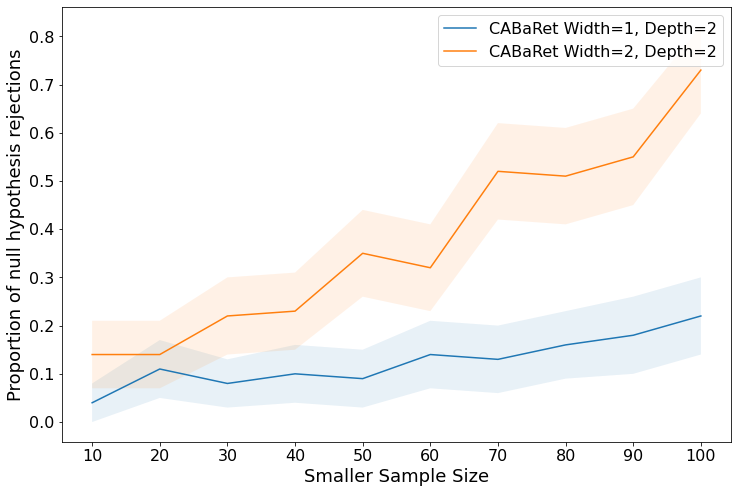

In [21]:
# iid
fig, ax = plt.subplots(figsize=(12,8))
i = 0
for file in files:
    lowers = np.around(cis_files_iid[file][:, 0], decimals=2)
    means = np.around(cis_files_iid[file][:, 1], decimals=2)
    uppers = np.around(cis_files_iid[file][:, 2], decimals=2)    
    x = np.linspace(10, 100, 10).astype(int)
    if (i == 0):
        label = 'CABaRet Width=1, Depth=2'
    else:
        label = 'CABaRet Width=2, Depth=2'
    ax.plot(x, means, label=label)
    ax.set_xticks(x)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.fill_between(x, lowers, uppers, alpha=.1)
    i+=1
#         plt.xlabel("Perturbed Distribution Sample")
plt.xlabel("Smaller Sample Size", fontsize=18)
plt.ylabel("Proportion of null hypothesis rejections", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.savefig("covertness_iid.pdf", format='pdf')

In [34]:
sim_results_path = '/home/mateus/NFR-master/Simulator/sim_results/'
files = []
files.append('sim_results_Umovielens1k_pop1_a0.8_N10_C10_CPtop_Q1.0_cabaret_W1_D2.json')
# files.append('sim_results_Umovielens1k_pop1_a0.8_N10_C10_CPtop_Q1.0_cabaret_W2_D2.json')
n_bots = [10, 20, 50]
cis_nbots_files_rw = {}
for nbots in n_bots:  
    cis_nbots_files_rw[nbots] = {}
    for file in files:        
        cis = get_rejections_cis_filename_rw(sim_results_path, file, nbots, 100) # iid
        cis_nbots_files_rw[nbots][file] = np.array(cis)

1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10,

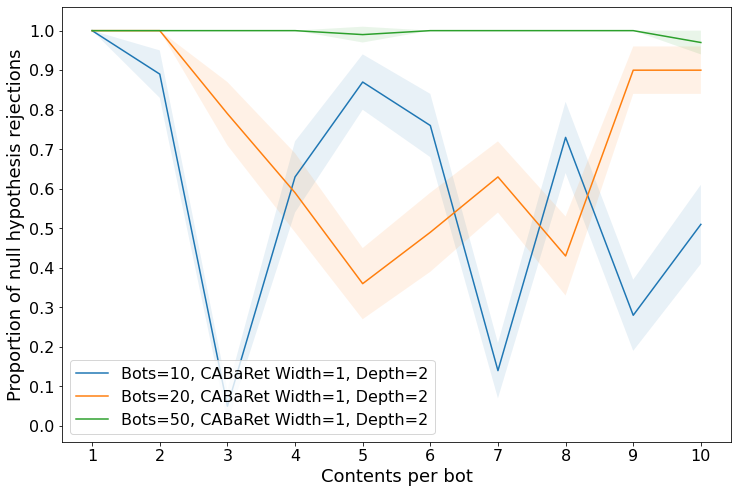

In [35]:
# rw
fig, ax = plt.subplots(figsize=(12,8))
i = 0
file = files[0]
for nbots in n_bots:
#     for file in files:
    lowers = np.around(cis_nbots_files_rw[nbots][file][:, 0], decimals=2)
    means = np.around(cis_nbots_files_rw[nbots][file][:, 1], decimals=2)
    uppers = np.around(cis_nbots_files_rw[nbots][file][:, 2], decimals=2)    
    x = np.linspace(1, 10, 10).astype(int)
    if (i == 0):
        label = 'Bots='+str(nbots) + ', CABaRet Width=1, Depth=2'
    else:
        label = 'Bots='+str(nbots) + ',CABaRet Width=2, Depth=2'
    ax.plot(x, means, label=label)
    ax.set_xticks(x)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.fill_between(x, lowers, uppers, alpha=.1)
#     i+=1
#         plt.xlabel("Perturbed Distribution Sample")
plt.xlabel("Contents per bot", fontsize=18)
plt.ylabel("Proportion of null hypothesis rejections", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.savefig("covertness_rw_bs1000_1_10.pdf", format='pdf')

In [79]:
# test_dist_sizes = np.linspace(10, 50, 10).astype(int)
# fig, ax = plt.subplots()
# plot_confidence_intervals(test_dist_sizes, "confidence_interval_test_sizetds10-50_rounds_100_bots_10.txt", fig, ax, 'Bots=10', 'b')
# plot_confidence_intervals(test_dist_sizes, "confidence_interval_test_sizetds10-50_rounds_100_bots_20.txt", fig, ax, 'Bots=20', 'g')
# plot_confidence_intervals(test_dist_sizes, "confidence_interval_test_sizetds10-50_rounds_100_bots_30.txt", fig, ax, 'Bots=30', 'r')
# plt.legend()
# # plt.savefig("proportions.png")

In [14]:
path = "/home/mateus/NFR-master/Simulator/sim_results/"
file = path + "sim_results_Ulastfm_pop0_a0.5_N2_C5_CPtop_Q0.5_L40.json"
# file = path + "sim_results_Ulastfm_pop0_a0.99_N2_C5_CPtop_Q0.5_L40.json"
x, y, z = rejections_in_function_of_sample_size_and_fairness(file)


In [15]:
# print(x)
# print(y)
print(z)

{'max': array([0.19056045, 0.19056045, 0.19056045, 0.19056045, 0.19056045,
       0.19056045, 0.19056045, 0.19056045, 0.19056045, 0.19056045]), 'avg': array([0.35668727, 0.35668727, 0.35668727, 0.35668727, 0.35668727,
       0.35668727, 0.35668727, 0.35668727, 0.35668727, 0.35668727]), 'kl-smooth-inv': array([0.09389285, 0.09389285, 0.09389285, 0.09389285, 0.09389285,
       0.09389285, 0.09389285, 0.09389285, 0.09389285, 0.09389285])}


In [16]:
# Getting non-optimal simulation results
sim_results = os.listdir(path)
print(len(sim_results))
optm_max = match_regex_array(sim_results, r'.*Fmax.*')
optm_max = [f.split('/sim_results/')[1] for f in optm_max]
optm_tv = match_regex_array(sim_results, r'.*FTV.*')
optm_tv = [f.split('/sim_results/')[1] for f in optm_tv]
optm_kl = match_regex_array(sim_results, r'.*FKL.*')
optm_kl = [f.split('/sim_results/')[1] for f in optm_kl]
sim_results = [sm for sm in sim_results if not os.path.isdir(path + sm) and sm not in optm_max + optm_tv + optm_kl]
print(len(sim_results))


1196
893


In [17]:
sim_results_selected = get_selected_scenarios("/home/mateus/NFR-master/Simulator/")

In [18]:
from random import choice, sample
# files_sample = sample(sim_results, k=50)
files_sample = sim_results_selected
X = []
Y = []
Z = []
i = 0
rows = []
for f in files_sample:
    print("i:", i, end=', ')
    i+=1
    try:
        x, y, z = rejections_in_function_of_sample_size_and_fairness(path+f)
        X.append(x)
        Y.append(y)
        Z.append(z)
        for f_metric in z.keys():
            rows.append({'File':f, 'SampleSize':x, 'Rejections':y, 'Fairness':z[f_metric], 'FairnessMetric':f_metric})
    except Exception as e:
        print(e)

i: 0, i: 1, i: 2, i: 3, i: 4, i: 5, i: 6, i: 7, i: 8, i: 9, i: 10, i: 11, i: 12, i: 13, i: 14, i: 15, i: 16, i: 17, i: 18, i: 19, i: 20, i: 21, i: 22, i: 23, i: 24, i: 25, i: 26, i: 27, i: 28, i: 29, i: 30, i: 31, i: 32, i: 33, i: 34, i: 35, i: 36, i: 37, i: 38, i: 39, i: 40, i: 41, i: 42, i: 43, i: 44, i: 45, i: 46, i: 47, i: 48, i: 49, i: 50, i: 51, i: 52, i: 53, i: 54, i: 55, i: 56, i: 57, i: 58, i: 59, i: 60, i: 61, i: 62, i: 63, i: 64, i: 65, i: 66, i: 67, i: 68, i: 69, i: 70, i: 71, i: 72, i: 73, i: 74, i: 75, i: 76, i: 77, i: 78, i: 79, i: 80, i: 81, i: 82, i: 83, i: 84, i: 85, i: 86, i: 87, i: 88, i: 89, i: 90, i: 91, i: 92, i: 93, i: 94, i: 95, i: 96, i: 97, i: 98, i: 99, i: 100, i: 101, i: 102, i: 103, i: 104, i: 105, i: 106, i: 107, i: 108, i: 109, i: 110, i: 111, i: 112, i: 113, i: 114, i: 115, i: 116, i: 117, i: 118, i: 119, i: 120, i: 121, i: 122, i: 123, i: 124, i: 125, i: 126, i: 127, i: 128, i: 129, i: 130, i: 131, i: 132, i: 133, i: 134, i: 135, i: 136, i: 137, i: 138

In [16]:

# df = pd.DataFrame(rows)
# df.to_csv("rejections_samplesize_fairness.csv")
df = pd.read_csv("rejections_samplesize_fairness.csv")
df.head()

,Unnamed: 0,File,SampleSize,Rejections,Fairness,FairnessMetric
0,0,sim_results_Ulastfm_pop0_a0.99_N2_C10_CPtop_Q0...,[ 10 20 30 40 50 60 70 80 90 100],"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[0.2201368 0.2201368 0.2201368 0.2201368 0.220...,max
1,1,sim_results_Ulastfm_pop0_a0.99_N2_C10_CPtop_Q0...,[ 10 20 30 40 50 60 70 80 90 100],"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[0.88816996 0.88816996 0.88816996 0.88816996 0...,avg
2,2,sim_results_Ulastfm_pop0_a0.99_N2_C10_CPtop_Q0...,[ 10 20 30 40 50 60 70 80 90 100],"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[0.69744987 0.69744987 0.69744987 0.69744987 0...,kl-smooth-inv
3,3,sim_results_Ulastfm_pop0_a0.99_N2_C10_CPtop_Q0...,[ 10 20 30 40 50 60 70 80 90 100],"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[0.2201368 0.2201368 0.2201368 0.2201368 0.220...,max
4,4,sim_results_Ulastfm_pop0_a0.99_N2_C10_CPtop_Q0...,[ 10 20 30 40 50 60 70 80 90 100],"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[0.88816996 0.88816996 0.88816996 0.88816996 0...,avg


In [62]:
def convert_array_string_to_int_array(l):
    return list(map(int, l.replace("[", "").replace("]", "").split()))
def convert_array_string_to_float_array_comma(l):
    return list(map(float, l.replace("[", "").replace("]", "").split(',')))
def convert_array_string_to_float_array(l):
    return list(map(float, l.replace("[", "").replace("]", "").split()))


In [63]:
df['SampleSize'].map(convert_array_string_to_int_array)

0       [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
1       [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
2       [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
3       [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
4       [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                          ...                    
1294    [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
1295    [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
1296    [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
1297    [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
1298    [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Name: SampleSize, Length: 1299, dtype: object

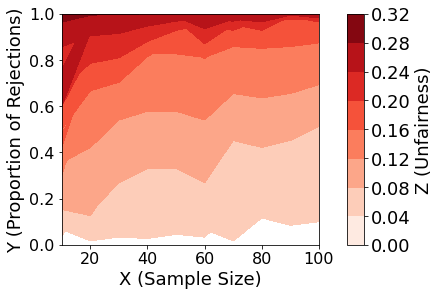

<Figure size 864x576 with 0 Axes>

In [133]:
df_max = df[df['FairnessMetric'] == 'max']
X = df_max['SampleSize'].map(convert_array_string_to_int_array).tolist()
Y = df_max['Rejections'].map(convert_array_string_to_float_array_comma).tolist()
Z = df_max['Fairness'].map(convert_array_string_to_float_array).tolist()
fig,ax=plt.subplots(1,1, constrained_layout=True)
cp = ax.contourf(X, Y, Z, cmap='Reds')
cbar = fig.colorbar(cp) # Add a colorbar to a plot
# cbar = plt.colorbar()
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=18)
cbar.ax.set_ylabel("Z (Unfairness)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('X (Sample Size)', fontsize=18)
ax.set_ylabel('Y (Proportion of Rejections)', fontsize=18)
# ax.yaxis.tick_right()
# ax2 = ax.twinx()
# ax2.set_ylabel('z (Unfairness)', fontsize=18)
plt.savefig("contour_fmax.eps", format='eps')
plt.figure(figsize=(12,8))
plt.show()

In [125]:
np.array(df_max['Fairness'].map(convert_array_string_to_float_array).tolist()).max()

0.31798688

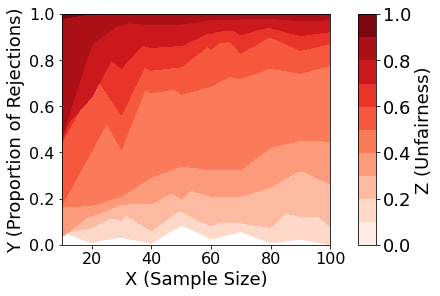

In [134]:
df_avg = df[df['FairnessMetric'] == 'avg']
X = df_avg['SampleSize'].map(convert_array_string_to_int_array).tolist()
Y = df_avg['Rejections'].map(convert_array_string_to_float_array_comma).tolist()
Z = df_avg['Fairness'].map(convert_array_string_to_float_array).tolist()
# Z_ = [z['avg'] for z in Z]
fig,ax=plt.subplots(1,1, constrained_layout=True)
cp = ax.contourf(X, Y, Z, cmap='Reds', levels=len(X)//40)
cbar = fig.colorbar(cp) # Add a colorbar to a plot
# cbar = plt.colorbar()
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=18)
cbar.ax.set_ylabel("Z (Unfairness)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('X (Sample Size)', fontsize=18)
ax.set_ylabel('Y (Proportion of Rejections)', fontsize=18)
# ax.yaxis.tick_right()
# ax2 = ax.twinx()
# ax2.set_ylabel('z (Unfairness)', fontsize=18)
plt.savefig("contour_ftv.eps", format='eps')
plt.show()

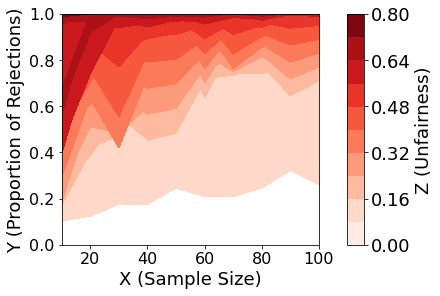

<Figure size 864x576 with 0 Axes>

In [136]:
df_kl = df[df['FairnessMetric'] == 'kl-smooth-inv']
X = df_kl['SampleSize'].map(convert_array_string_to_int_array).tolist()
Y = df_kl['Rejections'].map(convert_array_string_to_float_array_comma).tolist()
Z = df_kl['Fairness'].map(convert_array_string_to_float_array).tolist()
# Z_ = [z['kl-smooth-inv'] for z in Z]
fig,ax=plt.subplots(1,1, constrained_layout=True)
cp = ax.contourf(X, Y, Z, cmap='Reds', levels=len(X)//40)
cbar = fig.colorbar(cp) # Add a colorbar to a plot
# cbar = plt.colorbar()
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=18)
cbar.ax.set_ylabel("Z (Unfairness)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('X (Sample Size)', fontsize=18)
ax.set_ylabel('Y (Proportion of Rejections)', fontsize=18)
# ax.yaxis.tick_right()
# ax2 = ax.twinx()
# ax2.set_ylabel('z (Unfairness)', fontsize=18)
plt.savefig("contour_fkl.eps", format='eps')
plt.figure(figsize=(12,8))
plt.show()

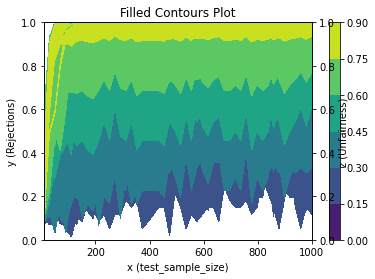

<Figure size 864x576 with 0 Axes>

In [205]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Z, Y)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (test_sample_size)')
ax.set_ylabel('y (Rejections)')
ax.yaxis.tick_right()
ax2 = ax.twinx()
ax2.set_ylabel('z (Unfairness)')
plt.figure(figsize=(12,8))
plt.show()

In [178]:
x = np.arange(5)
y = np.arange(5, 10)
np.meshgrid(x, y)

[array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]),
 array([[5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8],
        [9, 9, 9, 9, 9]])]

In [10]:
# rna = np.array(data_movielens['R_NA'])
# rows = rna.shape[0]
# means = []
# for i in range(rows):
#     ri = rna[i]
#     ri = ri[ri > 0]
#     means.append(len(ri))
# means

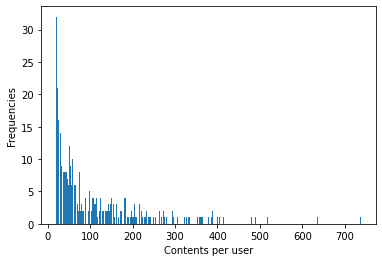

In [281]:
plt.bar(contents_per_user_population, contents_per_user_dist)
plt.xlabel("Contents per user")
plt.ylabel("Frequencies")
plt.savefig("contents_per_user_freq.png")

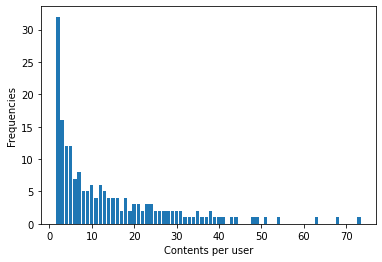

In [282]:
plt.bar(contents_per_user_population//10, contents_per_user_dist)
plt.xlabel("Contents per user")
plt.ylabel("Frequencies")
plt.savefig("contents_per_user_freq_div_10.png")

In [263]:
# save_confidence_intervals(cis, test_dist_sizes, nrounds, nbots)

[Errno 2] No such file or directory: 'confidence_interval_random_test_sizetds0-700_rounds_100_bots_50.txt'


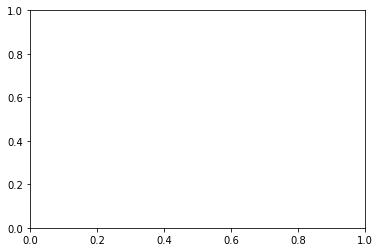

In [78]:
fig, ax = plt.subplots()
plot_confidence_intervals(n_bots, "confidence_interval_random_test_sizetds0-700_rounds_100_bots_50.txt", fig, ax, '', 'b')
plt.savefig("proportions_nbots.png")

In [23]:
# for the not aggregated case
# test_dist_sizes = np.linspace(10, 40, 4).astype(int)
# pvalues_mean_sample = []
# proportion_mean_sample = []
# confidence_intervals = []
# for tds in test_dist_sizes:
#     print(tds)
#     p_values_means, proportion_means = covertness_kstest(data_movielens['pi_bs'], data_movielens['pi_final_NA'], population_movielens, ref_dist_size=10**4, test_dist_size=tds, N_bots=50, rounds=30)
#     pvalues_mean_sample.append(p_values_means)
#     proportion_mean_sample.append(proportion_means)